# Astronomy Wordle Game System Project 
# Overview of project here...
# Team: Casey Batman & Andrew Schlemmer

# Andrew: Remaining Work
1. Write load_astronomy_words() function that takes a file_path of words and attached difficulty values and parse those into a dictionary. See the final cell of this notebook to see how we'd use that!
2. Write AstonomyExpert class to call LLM for hint based on a word if a guess fails and also a method that gives a fun fact about the word if the user guesses it correctly!
3. Add documentation markdown files to match each code cell (some exist, but need to be more detailed)

# Casey: Remaining Work
1. Finish plot_guess_distribution

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
# Import LLM here too
import litellm
astro1221_key = os.getenv("ASTRO1221_API_KEY")
# Constants
MAX_GUESSES = 6
WORD_LENGTH = 5
EASY_MODE = "Easy"
HARD_MODE = "Hard"
DATA_FILE = "words.csv"
CORRECT = "GREEN"
PRESENT = "YELLOW"
ABSENT = "GRAY"
GREEN_BG = "\033[42m\033[30m" # Green background, black text
YELLOW_BG = "\033[43m\033[30m" # Yellow background, black text
GRAY_BG = "\033[100m\033[97m"  # Bright gray background, white text
RESET = "\033[0m"              # Resets color to default
ASTRONOMY_GREEN = '#6aaa64'
PLOT_EDGE_COLOR = '#d3d6da'

# Stage 1: Logic & Data

In [28]:
# Function to load words from words.csv into a dictionary
def load_astronomy_words(file_path):
    """
    Loads a CSV file where the first column is a word and the second column is a value (e.g., difficulty).
    Returns a dictionary with the first column as keys and the second column as values.
    Assumes there is a header row which will be skipped.
    """
    astronomy_words = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            # Remove any leading/trailing whitespace and newlines
            line = line.strip()
            if not line:
                continue  # Skip empty lines
            # Skip header if present (i==0)
            if i == 0 and not line[0].isalpha():
                continue
            parts = line.split(',')
            if len(parts) < 2:
                continue  # Skip malformed lines
            key = parts[0].strip()
            value = parts[1].strip()
            astronomy_words[key] = value
    return astronomy_words
load_astronomy_words(r"words.csv")
# Verify that the function successfully loaded the CSV file by printing the result
print(load_astronomy_words(r"words.csv"))

{'Word': 'diffictulty', 'stars': 'easy', 'quark': 'hard', 'aries': 'easy', 'comet': 'easy', 'earth': 'easy', 'orbit': 'easy', 'virgo': 'hard', 'astro': 'easy', 'atlas': 'hard', 'ceres': 'hard', 'cetus': 'easy', 'helix': 'hard', 'libra': 'easy', 'orion': 'hard', 'pluto': 'easy', 'novae': 'hard', 'cosmo': 'hard', 'pyxis': 'hard', 'titan': 'easy', 'venus': 'planet', 'solar': 'easy', 'flare': 'easy', 'giant': 'easy', 'dwarf': 'hard', 'moons': 'hard', 'nodes': 'easy', 'phase': 'easy', 'light': 'easy', 'space': 'easy', 'radio': 'easy', 'gamma': 'hard', 'inner': 'easy', 'probe': 'easy', 'rover': 'easy', 'array': 'hard', 'outer': 'easy', 'local': 'easy', 'cycle': 'hard', 'focus': 'hard', 'lupus': 'hard'}


In [12]:
class WordleGame:
    """Handles the algorithmic 'Wordle' logic for character matching."""
    def __init__(self, secret_word):
        self.secret_word = secret_word.upper()
        self.secret_word_char_freq = self.count_chars(secret_word)

    def count_chars(self, input_string):
        char_counts = {}
        for char in input_string:
            char_counts[char] = char_counts.get(char, 0) + 1
        return char_counts
        
    def check_guess(self, user_guess):
        user_guess = user_guess.upper()
        guess_result = [None] * len(user_guess)
        remaining_letter_budget = self.secret_word_char_freq.copy()

        # Identify GREEN Letters (Correct Position)
        for i in range(len(user_guess)):
            if user_guess[i] == self.secret_word[i]:
                guess_result[i] = CORRECT
                remaining_letter_budget[user_guess[i]] -= 1

        # Identify YELLOW vs GRAY Characters
        for i in range(len(user_guess)):
            # Skip if already marked GREEN
            if guess_result[i] is not None:
                continue
            char = user_guess[i]
            
            # If char exists in word AND we haven't exhausted its count
            if char in self.secret_word and remaining_letter_budget.get(char, 0) > 0:
                guess_result[i] = PRESENT
                remaining_letter_budget[char] -= 1
            else:
                guess_result[i] = ABSENT
        
        return guess_result

# This check_guess function requires two passes: once to decide the green letters, another to decide with frequency analysis whether the remaining characters should be yellow or gray

Example 1: EVENS vs GREENS
Pass 1: It sees the second 'E' in EVENS matches the 'E' in GREEN at that exact spot. It marks it GREEN and reduces the 'E' budget from 2 down to 1.

Pass 2: It looks at the first 'E'. There is still 1 'E' left in the budget. It marks it YELLOW and reduces budget to 0.

Result: [YELLOW, GRAY, GRAY, GREEN, GRAY]

Example 2: EVENS vs GREAT
Pass 1: The second 'E' in EVENS matches the 'E' in GREAT. Mark GREEN, budget for 'E' goes from 1 to 0.

Pass 2: The first 'E' is checked. The budget for 'E' is now 0. It is marked GRAY.

Result: [GRAY, GRAY, GRAY, GREEN, GRAY]

In [13]:
# wordle_game = WordleGame("COMET") # In future development, by this point, we want to make sure this word is already checked for input
def test_wordle_logic():
    """Verifies the tricky double-letter scenarios."""
    
    # Scenario: Secret=GREEN, Guess=EVENS
    # Expected: E is yellow (pos 0), second E is green (pos 3)
    game1 = WordleGame("GREEN")
    res1 = game1.check_guess("EVENS")
    assert res1 == [PRESENT, ABSENT, CORRECT, PRESENT, ABSENT], f"Failed EVENS/GREEN: {res1}"
    
    # Scenario: Secret=GREAT, Guess=EVENS
    # Expected: First E is gray, second E is green
    game2 = WordleGame("GREAT")
    res2 = game2.check_guess("EVENS")
    assert res2 == [ABSENT, ABSENT, CORRECT, ABSENT, ABSENT], f"Failed EVENS/GREAT: {res2}"
    
    print("✅ Wordle Logic Scenarios Passed!")

test_wordle_logic()

✅ Wordle Logic Scenarios Passed!


# Stage 2: User Experience & State Management
Game Flow and Player Persistence

In [14]:
class PlayerStats:
    """Tracks lifetime wins and guess distributions using NumPy."""
    def __init__(self, filename="player_stats.npy"):
        self.filename = filename
        # Initialize NumPy array for distributions [1st guess wins, 2nd, ..., 6th]
        self.distribution = self._load_stats()

    def _load_stats(self):
        file_found = os.path.exists(self.filename)
        if file_found:
            try:
                data = np.load(self.filename)
                # Ensure the loaded data is the correct shape as a TUPLE!
                if data.shape == (6,):
                    return data
            except Exception as e:
                print(f"[DEBUG] Load error: {e}")
        else:
            return np.zeros(MAX_GUESSES, dtype=int)
        
    def _save_stats(self):
        np.save(self.filename, self.distribution)
        if not os.path.exists(self.filename):
             print(f"[ERROR] Failed to write to {self.filename}")

    def record_win(self, guess_number):
        # Guess must be between 1 and 6
        if 1 <= guess_number <= 6:
            index = guess_number - 1
            self.distribution[index] += 1
            self._save_stats()
        else:
            raise ValueError("Guess number must be between 1 and 6")

#     def get_win_percentage(self): # Can be expanded for Matplotlib work later!
#         wins = np.sum(self.distribution)
#         return wins


In [15]:
def test_player_stats():
    """Unit test to verify NumPy persistence and distribution tracking."""
    test_file = "test_stats.npy"
    
    # Cleanup any old test files
    if os.path.exists(test_file):
        os.remove(test_file)
        
    # Initialize
    stats = PlayerStats(filename=test_file)
    
    # Test 1: Verify initial state is all zeros
    np.testing.assert_array_equal(stats.distribution, np.zeros(MAX_GUESSES, dtype=int))
    
    # Test 2: Record a win on the 3rd guess
    stats.record_win(3)
    expected_after_one_win = np.array([0, 0, 1, 0, 0, 0])
    np.testing.assert_array_equal(stats.distribution, expected_after_one_win)
    
    # Test 3: Record a win on the 1st guess and verify persistence
    stats.record_win(1)
    # Reload from file to ensure it actually saved
    new_stats_instance = PlayerStats(filename=test_file)
    expected_final = np.array([1, 0, 1, 0, 0, 0])
    np.testing.assert_array_equal(new_stats_instance.distribution, expected_final)
    
    # Cleanup
    os.remove(test_file)
    print("✅ PlayerStats Unit Tests Passed!")

# Run the test
test_player_stats()

✅ PlayerStats Unit Tests Passed!


In [ ]:
from typing import Any


class GameFlow:
    """Orchestrates the CLI Wordle experience and state."""
    
    def __init__(self, word_list):
        self.word_list = word_list
        self.stats = PlayerStats()
        self.ui = AstronomyVisualizer()
        self.current_game = None
        self.is_hard_mode = False # Defrault
        self.last_guess = None
        self.last_results = None

    def start_game(self):
        """Main entry point with game mode reset capabilities."""
        self.ui.print_header("WELCOME TO ASTRONOMY WORDLE")
        self._configure_settings()
        
        while True:
            # Round Setup
            secret_word = self._get_random_word()
            self.current_game = WordleGame(secret_word)
            self.last_guess = None
            self.last_results = None
            
            # Play the round
            won = self._run_guess_loop()
            
            # Post-game: Show stats and ask for next steps
            plot_guess_distribution(self.stats)
            
            if not self._handle_post_game_options():
                print("Finalizing mission logs... Goodbye!")
                break

    def _configure_settings(self):
        """Prompt user for game preferences with strict input validation."""
        self.ui.print_header("GAME SETTINGS")
        
        print("MODES:")
        print("[1] Normal: Standard Wordle rules.")
        print("[2] Hard: Revealed hints must be used in subsequent guesses.")
        
        while True:
            choice = input("\nSelect mode (1 or 2): ").strip()
            
            if choice == "1":
                self.is_hard_mode = False
                print(">>> NORMAL MODE SELECTED.")
                break
            elif choice == "2":
                self.is_hard_mode = True
                print(">>> HARD MODE ACTIVATED. Clear skies and good luck.")
                break
            else:
                print(f"Invalid selection: '{choice}'. Please enter 1 for Normal or 2 for Hard.")

    def _run_guess_loop(self):
        all_attempts = []
        for attempt in range(1, MAX_GUESSES + 1):
            self.ui.display_game_board(all_attempts)
            
            guess = self._get_valid_user_input()
            results = self.current_game.check_guess(guess)
            
            # Store state for Hard Mode check
            self.last_guess = guess
            self.last_results = results
            all_attempts.append((guess, results))
            
            if all(res == CORRECT for res in results):
                self.ui.display_game_board(all_attempts)
                print(f"🌟 DISCOVERY! You identified {self.current_game.secret_word} in {attempt} tries.")
                self.stats.record_win(attempt)
                return True
        
        self.ui.display_game_board(all_attempts)
        print(f"🔭 MISSION FAILED. The term was: {self.current_game.secret_word}")
        return False

    def _get_valid_user_input(self):
        while True:
            guess = input("Enter a 5-letter astronomy term: ").upper()
            is_invalid_length = len(guess) != WORD_LENGTH
            is_not_alphabetical = not guess.isalpha() 
            if is_invalid_length or is_not_alphabetical:
                print("Invalid input. Please enter exactly 5 letters.")
                continue 

            if self.is_hard_mode and self.last_results:
                is_valid, message = validate_hard_mode(self.last_guess, self.last_results, guess)
                if not is_valid:
                    print(message)
                    continue
            return guess

    def _handle_post_game_options(self):
        """
        Handles the logic after a game ends. 
        Returns True to play again, False to quit.
        """
        while True:
            print("\n[P] Play Again | [S] Change Mode (Hard/Normal) | [Q] Quit")
            choice = input("Select an option: ").strip().upper()

            if choice == 'P':
                return True
            elif choice == 'Q':
                return False
            elif choice == 'S':
                # Call the settings method you built earlier
                self._configure_settings()
                # After changing settings, ask again or just start the game
                print("\nSettings updated! Ready to play?")
                return True
            else:
                print(f"'{choice}' is not a valid option.")

    def _get_random_word(self):
        # Logic to pull from Andrew's dictionary when added
        return np.random.choice(list[Any](self.word_list.keys()))

    def _should_play_again(self):
        choice = input("Play again? (y/n): ").lower()
        return choice == 'y'

In [17]:
def validate_hard_mode(previous_guess, results, current_guess):
    """
    Ensures the current guess follows Hard Mode rules:
    1. Any GREEN letter must stay in the same position.
    2. Any YELLOW letter must be present somewhere in the new guess.
    """
    # Check for GREEN constraints
    for i in range(len(results)):
        if results[i] == CORRECT:
            if current_guess[i] != previous_guess[i]:
                return False, f"Hard Mode: Letter '{previous_guess[i]}' must be at position {i+1}"

    # Check for YELLOW constraints
    for i in range(len(results)):
        if results[i] == PRESENT:
            char_to_find = previous_guess[i]
            if char_to_find not in current_guess:
                return False, f"Hard Mode: Must include the letter '{char_to_find}'"
                
    return True, "Valid"

In [37]:
def test_hard_mode_logic():
    """Unit tests for Wordle Hard Mode constraint enforcement."""
    
    # Setup a scenario: 
    # Secret word: COMET. 
    # Previous Guess: COILS 
    # Results: [Green, Green, Gray, Gray, Gray] (C and O are fixed)
    prev_guess = "COILS"
    prev_results = [CORRECT, CORRECT, ABSENT, ABSENT, ABSENT]

    # Test Case 1: Valid follow-up (Pass)
    # Current Guess: COUNT (Keeps the C and O)
    is_valid, msg = validate_hard_mode(prev_guess, prev_results, "COUNT")
    assert is_valid == True, f"Failed valid guess: {msg}"

    # Test Case 2: Violation of GREEN rule (Fail)
    # Current Guess: BOATS (Changed the C to a B)
    is_valid, msg = validate_hard_mode(prev_guess, prev_results, "BOATS")
    assert is_valid == False
    assert "must be at position 1" in msg, f"Incorrect error message for Green: {msg}"

    # Setup a scenario for YELLOW:
    # Secret: STARS
    # Previous: SOLAR (S is Green, R is Yellow)
    prev_guess_2 = "SOLAR"
    prev_results_2 = [CORRECT, ABSENT, ABSENT, ABSENT, PRESENT]

    # Test Case 3: Violation of YELLOW rule (Fail)
    # Current Guess: SONIC (Keeps S, but drops the R)
    is_valid, msg = validate_hard_mode(prev_guess_2, prev_results_2, "SONIC")
    assert is_valid == False
    assert "Must include the letter 'R'" in msg, f"Incorrect error message for Yellow: {msg}"

    print("✅ Hard Mode Validation Tests Passed!")

# Run the test
test_hard_mode_logic()

✅ Hard Mode Validation Tests Passed!


In [18]:
class AstronomyVisualizer:
    """Handles all CLI rendering and color formatting for the game."""
    
    def __init__(self):
        pass 

    def print_header(self, title):
        """Prints a consistent, pretty header for game sections."""
        print("\n" + "="*40)
        print(f"{title.center(40)}")
        print("="*40 + "\n")

    def display_colored_row(self, guess, results):
        """Refined CLI visualization using color blocks."""
        color_map = {
            CORRECT: GREEN_BG,
            PRESENT: YELLOW_BG,
            ABSENT: GRAY_BG
        }
        
        formatted_output = ""
        for char, status in zip(guess, results):
            color = color_map.get(status, RESET)
            formatted_output += f"{color} {char} {RESET} "
        print(f"    {formatted_output}")

    def display_game_board(self, all_attempts):
        """Displays the full Wordle grid including past guesses and empty slots."""
        self.print_header("ASTRONOMY WORDLE")
        
        # Print past guesses
        for g_text, g_results in all_attempts:
            self.display_colored_row(g_text, g_results)
        
        # Fill remaining empty rows
        remaining = MAX_GUESSES - len(all_attempts)
        for _ in range(remaining):
            print("     [ ] [ ] [ ] [ ] [ ]  ")
        print("\n" + "-"*40)

# Stage 3: LLM Assistance and Performance Analytics

In [ ]:
class AstronomyExpert:
    """Connects to LLM API for hints and space facts."""
    def generate_hint(self, current_word):

        system_prompt = (
            "You are an Astronomy Expert assisting with the progression of an astronomy Wordle game."
        )
        user_prompt = (
            f'Generate a cryptic hint that does not explicitly reveal the word. '
            f'The word is: "{current_word}".'
        )
        completion = litellm.completion(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            max_tokens=60,
            temperature=0.7,
        )
        # Extract the hint from the LLM response
        return completion.choices[0].message.content.strip()
    def provide_space_fact(self, word):
        user_prompt = (
            f'Generate a 1 to 2 sentence fun fact about the word "{word}".'
        )
        completion = litellm.completion(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "user", "content": user_prompt}
            ],
            max_tokens=60,
            temperature=0.7,
        )
        # Extract the fact from the LLM response
        return completion.choices[0].message.content.strip()

In [20]:
def plot_guess_distribution(stats_obj):
    """
    Visualizes the player's performance using a horizontal bar chart.
    Demonstrates mastery of NumPy data handling and Matplotlib styling.
    """
    attempts = np.arange(1, 7)  # [1, 2, 3, 4, 5, 6]
    counts = stats_obj.distribution
    total_wins = np.sum(counts)
    
    # 2. Create Plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(attempts, counts, color=ASTRONOMY_GREEN, edgecolor=PLOT_EDGE_COLOR)
    
    # 3. Aesthetics & Labelling
    plt.title("Astronomy Wordle: Guess Distribution", fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Number of Wins", fontsize=12)
    plt.ylabel("Guess Number", fontsize=12)
    
    # Ensure y-axis shows all attempts 1-6 clearly
    plt.yticks(attempts)
    plt.gca().invert_yaxis()  # Put 1 at the top
    
    # 4. Add Data Labels (Show the actual number at the end of each bar)
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                 f'{int(width)}', va='center', fontweight='bold')

    # 5. Add a performance summary in a textbox
    stats_text = f"Total Discoveries: {total_wins}"
    plt.annotate(stats_text, xy=(0.5, -0.15), xycoords='axes fraction', 
                 ha='center', fontsize=12, bbox=dict(boxstyle="round", fc="none", ec="gray"))

    plt.tight_layout()
    plt.show()

# Game Stage:  
The "Play" Cell to actually launch the full application


      WELCOME TO ASTRONOMY WORDLE       


             GAME SETTINGS              

MODES:
[1] Normal: Standard Wordle rules.
[2] Hard: Revealed hints must be used in subsequent guesses.
Invalid selection: ''. Please enter 1 for Normal or 2 for Hard.
Invalid selection: ''. Please enter 1 for Normal or 2 for Hard.
Invalid selection: ''. Please enter 1 for Normal or 2 for Hard.
Invalid selection: ''. Please enter 1 for Normal or 2 for Hard.
Invalid selection: ''. Please enter 1 for Normal or 2 for Hard.
Invalid selection: ''. Please enter 1 for Normal or 2 for Hard.
Invalid selection: ''. Please enter 1 for Normal or 2 for Hard.
Invalid selection: ''. Please enter 1 for Normal or 2 for Hard.
Invalid selection: ''. Please enter 1 for Normal or 2 for Hard.
Invalid selection: ''. Please enter 1 for Normal or 2 for Hard.
Invalid selection: ''. Please enter 1 for Normal or 2 for Hard.
Invalid selection: ''. Please enter 1 for Normal or 2 for Hard.
Invalid selection: ''. Please enter 1 for N

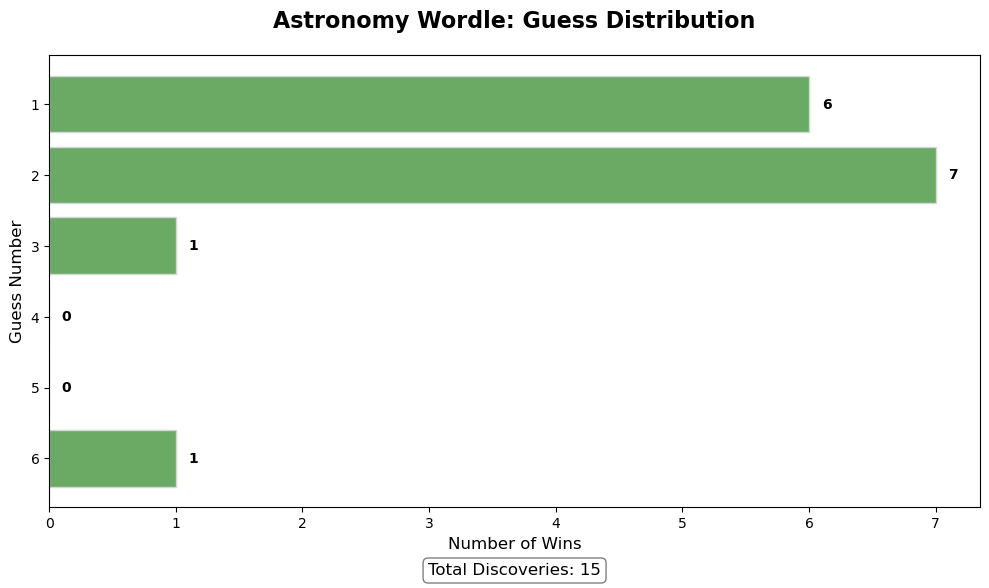


[P] Play Again | [S] Change Mode (Hard/Normal) | [Q] Quit
'' is not a valid option.

[P] Play Again | [S] Change Mode (Hard/Normal) | [Q] Quit
'' is not a valid option.

[P] Play Again | [S] Change Mode (Hard/Normal) | [Q] Quit
'' is not a valid option.

[P] Play Again | [S] Change Mode (Hard/Normal) | [Q] Quit
'' is not a valid option.

[P] Play Again | [S] Change Mode (Hard/Normal) | [Q] Quit
'' is not a valid option.

[P] Play Again | [S] Change Mode (Hard/Normal) | [Q] Quit
'' is not a valid option.

[P] Play Again | [S] Change Mode (Hard/Normal) | [Q] Quit
'' is not a valid option.

[P] Play Again | [S] Change Mode (Hard/Normal) | [Q] Quit
'' is not a valid option.

[P] Play Again | [S] Change Mode (Hard/Normal) | [Q] Quit
'' is not a valid option.

[P] Play Again | [S] Change Mode (Hard/Normal) | [Q] Quit
'' is not a valid option.

[P] Play Again | [S] Change Mode (Hard/Normal) | [Q] Quit
'' is not a valid option.

[P] Play Again | [S] Change Mode (Hard/Normal) | [Q] Quit
'' is 

In [22]:
sample_word_list = {"COSMO": "EASY", "COMET": "EASY", "NOVAS": "HARD"}
game_system = GameFlow(sample_word_list)
game_system.start_game()